<a href="https://colab.research.google.com/github/halizz821/DeepLearning_HSI_Classification/blob/main/3D_CNN/HyperspectralClassification3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mountin Google Drive

In [ ]:
####### Mounting your google drive
from google.colab import drive
drive.mount('/content/drive')

####### Data address in google drive
%cd /content/drive/MyDrive/Colab Notebooks/DeepLearning-HSI classification

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DeepLearning-HSI classification


# Import Libraries

In [ ]:
!pip install earthpy

import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, MaxPooling3D, Dropout, Flatten, Conv3D, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

seed(11)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## GLOBAL VARIABLES
windowSize = 3

# Functions

In [ ]:
def ExtractPatches(img,GT=None, windowSize=3):
# This function divied the input image into patches making it ready for training your algorithm
# img: your image
# GT= your ground truth image. If you do not have any GT, just leave it
# windowSize: the size of each patch

  if GT is None:
        GT=np.ones_like(img[:,:,0]) # if the GT is not define, we create a dummy GT. In this case, you should ignore the output 'labels'

  margin = int((windowSize - 1) / 2) # margin to be added into your image
  img=np.pad(img, pad_width=((margin,margin),(margin,margin),(0,0)),mode='edge') # padding the input image according to the margin

  a=np.asarray(np.where(GT!=0)).T # find the labled data in ground truth gt
  labels= GT[a[:,0],a[:,1]] #label of the samples

  ExtractedPatches=[]
  for i in a:
    b=img[i[0]:i[0]+2*margin+1,i[1]:i[1]+2*margin+1,:] # extract patches
    ExtractedPatches.append(b)

  return np.asanyarray(ExtractedPatches), labels
#######################################################################

def ScaleData(X,min_value,max_value):
  #This function sclae the data 'X' between 0 and 1
  X -= min_value
  X /= (max_value - min_value)
  return X

# Load Data

In [ ]:
################## X data (1096, 715, 102)   Hyperspectral satellite   (1096*715, 102)
data = loadmat('Pavia.mat')['pavia'].astype(np.float16)


###################### Y data (labels)
gt = loadmat('Pavia_gt.mat')['pavia_gt']

print(f'Data Shape: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}')

Data Shape: (1096, 715)
Number of Bands: 102


# Data Visualization

*This section of code is not necessary and you can skip it. It just visuallizes some spectral bands of the input image to get familiar with your data*

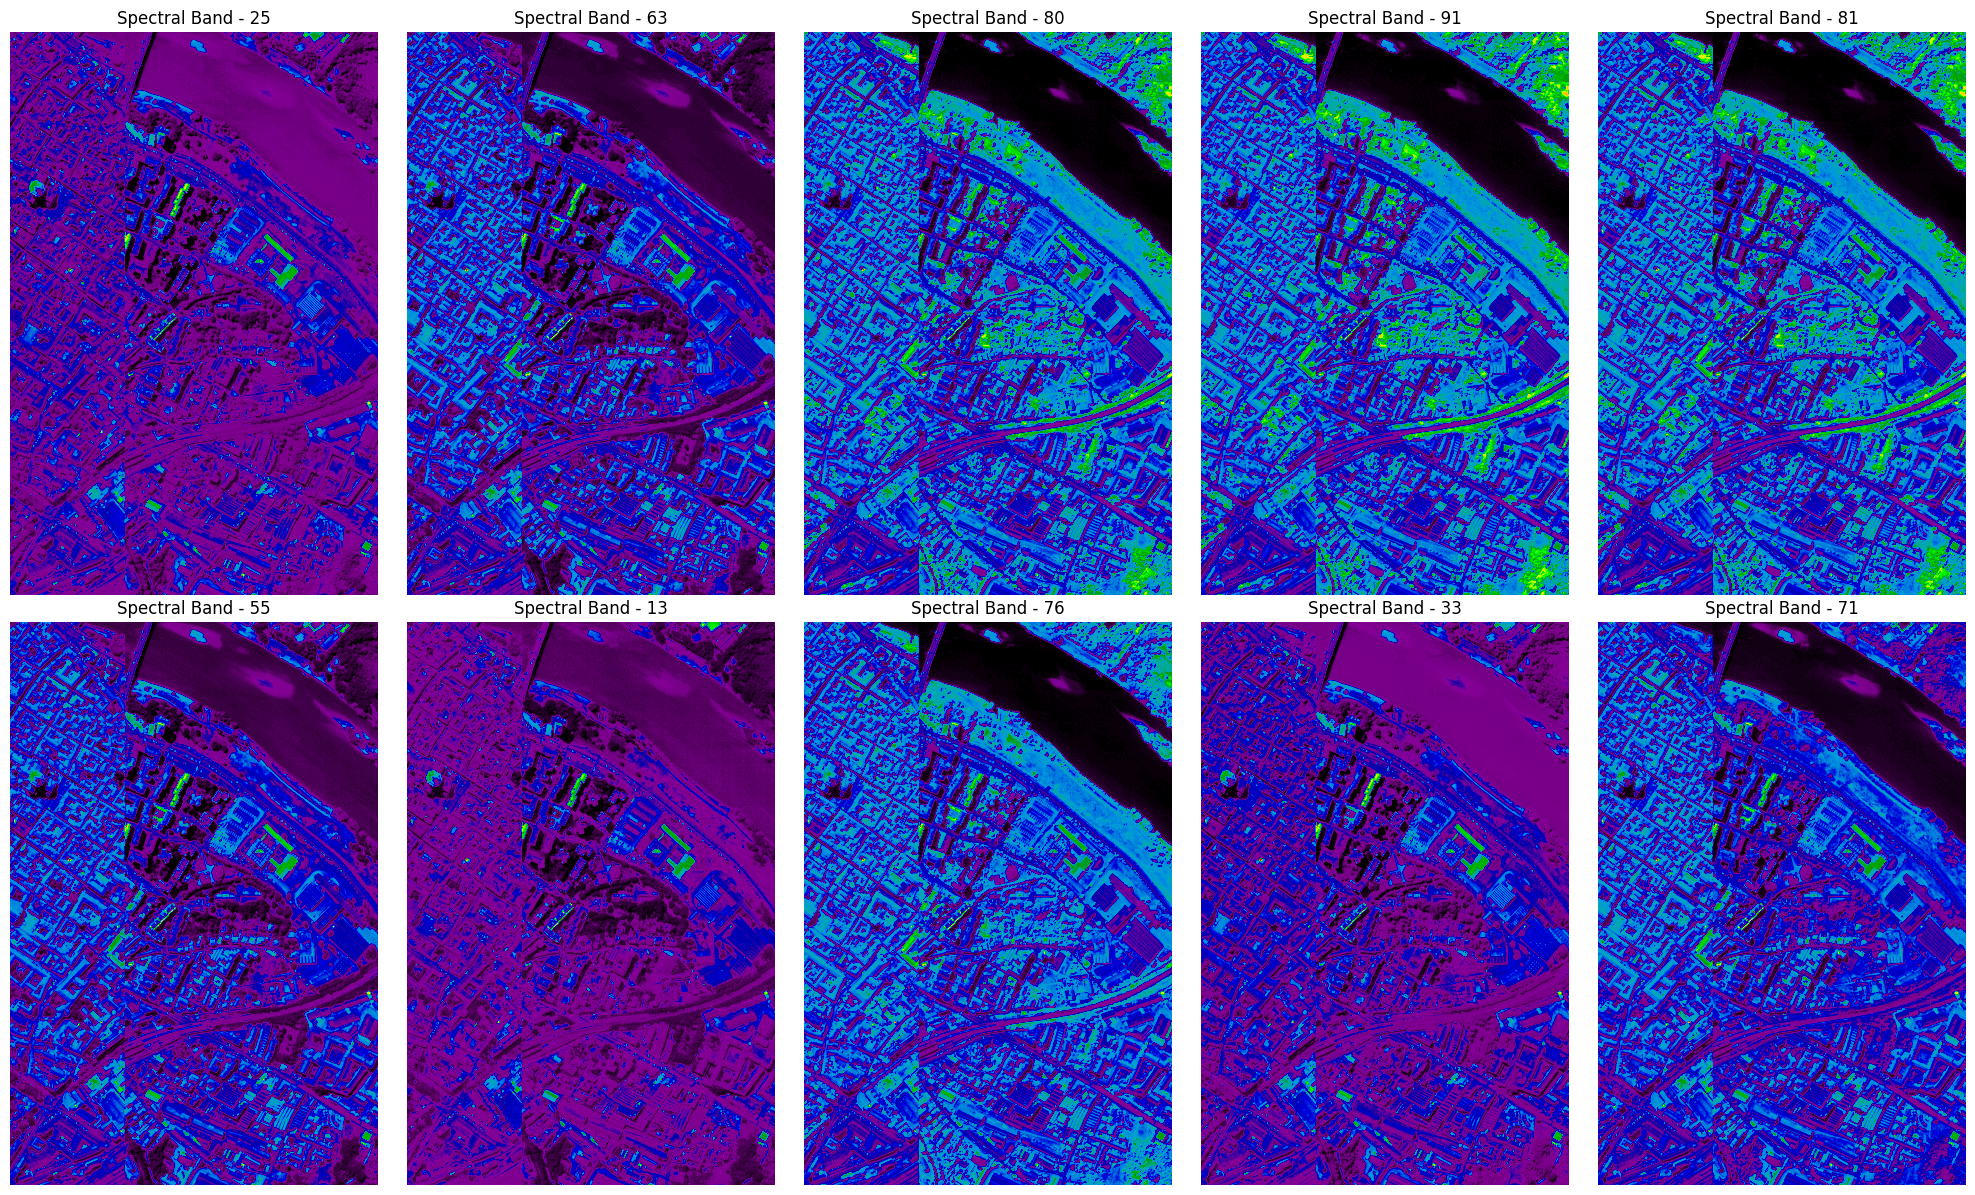

In [ ]:
fig = plt.figure(figsize = (20, 12))  # open a figure

ax = fig.subplots(2, 5) # divide the figure into several subfigures

##### plot each subplot
for i in range(2):
  for j in range(5):
    c = np.random.randint(data.shape[2]) ### randomely select a spectral band
    ax[i][j].imshow(data[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Spectral Band - {c}") # title
    c+=1

plt.tight_layout()
plt.show()


# RGB Composite Visualization

*This section of code is not necessary and you can skip it. It just visuallizes an RGB color composite of the input image to get familiar with your data*

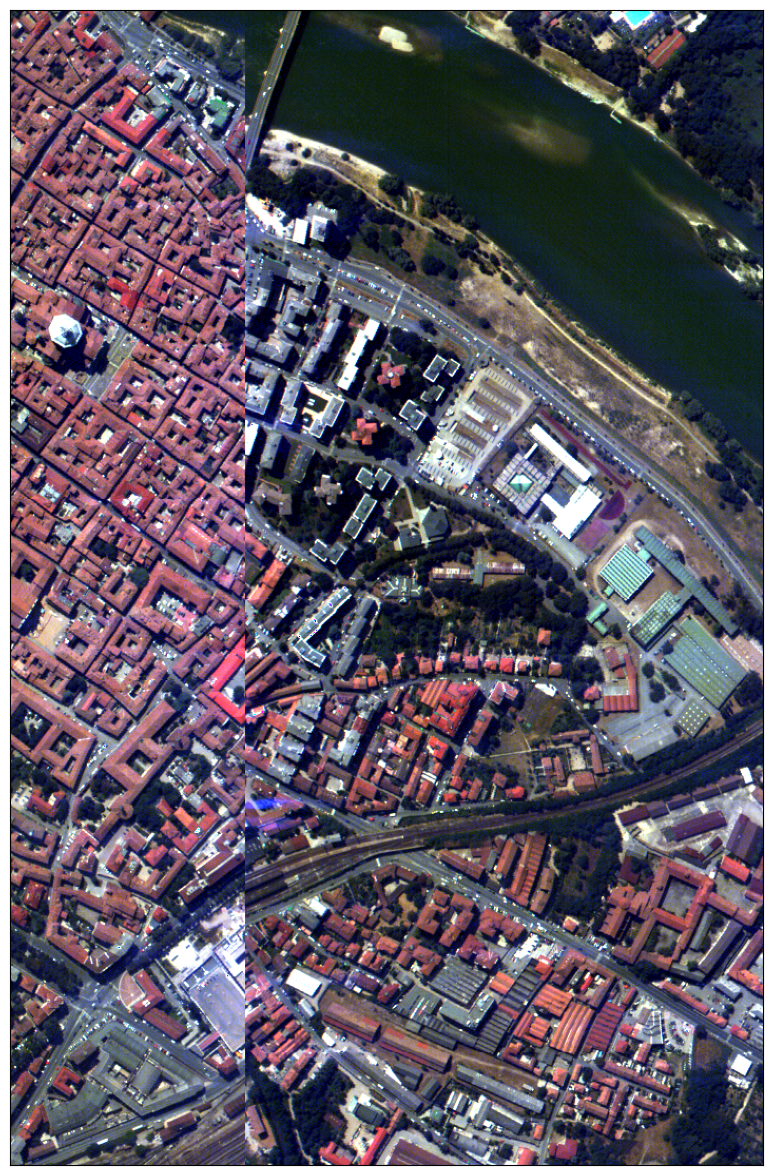

In [ ]:
mdata = np.moveaxis(data, -1, 0) # becauase mdata in ep.plot_rgb shoould be An n-dimensional array in rasterio band order (bands, rows, columns) containing the layers to plot.
R=50 # Red spectral band number
G=23 # Green spectral band number
B=2  # Blue spectral band number
ep.plot_rgb(mdata, (R,G,B), figsize=(15, 15),stretch=True)  # Plot red, green, and blue bands, respectively

plt.show()

# GroundTruth Visualizaation

*This section of code is not necessary and you can skip it. It just visuallizes your ground truth to get more familiar with your data*

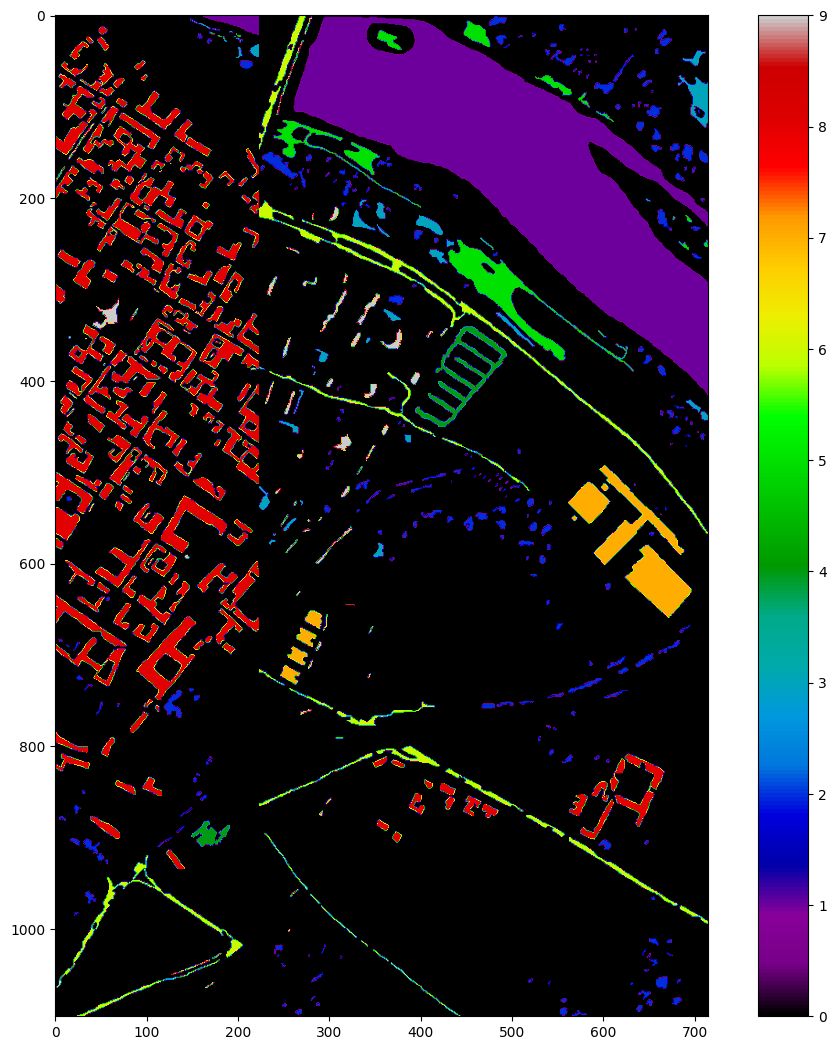

In [ ]:
def plot_data(data):
  fig = plt.figure(figsize=(13, 13)) # open a figure
  plt.imshow(data, cmap='nipy_spectral') #plot the groud truth
  plt.colorbar() # add colorbar
  plt.axis('on') # Trun the axis on
  plt.show()

plot_data(gt)

# Pre-processing
This step includes:

  1) Extract patches of the image

  2) Encode labels of each class

  3) Split samples into training, validation and test samples

  4) Scaling samples to [0,1] interval

In [ ]:

################# Extract patches of the the image
X, labels = ExtractPatches(data,GT=gt, windowSize=windowSize)

################# Encode labels of each class

enc = OneHotEncoder()
y=enc.fit_transform(labels.reshape(-1, 1)).toarray() #turn labels to categorical (i.e., each label is represented by a vector) usig  OneHotEncoder method

################# Split samples into: 1) Training, 2) Validation and 3) Test samples

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    train_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    stratify=y_train,
                                                    train_size=0.7)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_validation: {X_val.shape}\ny_validation: {y_val.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

################ Scaling

# Find the minimum and maximum values of the array
min_value = np.min(X_train)
max_value = np.max(X_train)

# Scale the array between 0 and 1
X_train=ScaleData(X_train,min_value,max_value)
X_val=ScaleData(X_val,min_value,max_value)
X_test=ScaleData(X_test,min_value,max_value)



X_train: (20741, 3, 3, 102)
y_train: (20741, 9)
X_validation: (8889, 3, 3, 102)
y_validation: (8889, 9)
X_test: (118522, 3, 3, 102)
y_test: (118522, 9)


# Build CNN

In [ ]:
ip_shape = X_train[0].shape # input shape of model
n_outputs = y_train.shape[1] # output shape of model

In [ ]:
model = Sequential(name = 'Pavia_3DCNN')

model.add(Conv3D(16, kernel_size=(2, 2, 2),activation='linear',padding='same',input_shape=ip_shape+(1,))) # I added (1,) because 3D-Conv expects a 4D tensor like (3,3,102,1)
model.add(LeakyReLU(alpha=0.1))
#model.add(MaxPooling2D((2, 2),padding='same'))

model.add(Conv3D(32, (3, 3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Conv3D(8, (3, 3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

model.add(Flatten())

model.add(Dense(20, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

model.add(Dense(n_outputs, activation='softmax'))
model.summary()

Model: "Pavia_3DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 3, 3, 102, 16)     144       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 3, 3, 102, 16)     0         
                                                                 
 conv3d_6 (Conv3D)           (None, 3, 3, 102, 32)     13856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 3, 3, 102, 32)     0         
                                                                 
 conv3d_7 (Conv3D)           (None, 3, 3, 102, 8)      6920      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 3, 3, 102, 8)      0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 2, 51, 8)      

# Train CNN model

In [ ]:
######## compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

######## define calback of the model
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Pavia_Model3.h5',
                             monitor = 'val_loss',
                             mode ='min',
                             save_best_only = True) # save the model with the best loss performance on validation data

tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

########## Fit the model on training samples
hist = model.fit(X_train,
                       y_train,
                       epochs = 20, #No of epochs
                       batch_size = 64, # batch size
                       validation_data = (X_val, y_val), # validation data
                       callbacks=[early_stop,
                                  checkpoint,
                                  tensorboard])


Epoch 1/20
325/325 [==============================] - 20s 24ms/step - loss: 0.4408 - accuracy: 0.8655 - val_loss: 0.0987 - val_accuracy: 0.9656
Epoch 2/20
325/325 [==============================] - 6s 17ms/step - loss: 0.1290 - accuracy: 0.9553 - val_loss: 0.0701 - val_accuracy: 0.9758
Epoch 3/20
325/325 [==============================] - 5s 14ms/step - loss: 0.1001 - accuracy: 0.9661 - val_loss: 0.0616 - val_accuracy: 0.9753
Epoch 4/20
325/325 [==============================] - 7s 22ms/step - loss: 0.0917 - accuracy: 0.9678 - val_loss: 0.0499 - val_accuracy: 0.9803
Epoch 5/20
325/325 [==============================] - 5s 15ms/step - loss: 0.0824 - accuracy: 0.9699 - val_loss: 0.0565 - val_accuracy: 0.9762
Epoch 6/20
325/325 [==============================] - 5s 15ms/step - loss: 0.0782 - accuracy: 0.9717 - val_loss: 0.0504 - val_accuracy: 0.9827
Epoch 7/20
325/325 [==============================] - 4s 11ms/step - loss: 0.0781 - accuracy: 0.9730 - val_loss: 0.0520 - val_accuracy: 0.982

# Plot results (loss and accuracy) of all epochs

In [ ]:
# %load_ext tensorboard

# %tensorboard --logdir SA_logs/

In [ ]:
hist = pd.DataFrame(data= hist.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

# Validate the performance of the model

3704/3704 [==============================] - 15s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52779
           1       0.94      0.98      0.96      5861
           2       0.94      0.87      0.90      2683
           3       0.99      0.72      0.83      2965
           4       0.88      0.99      0.93      4657
           5       0.99      0.97      0.98      7557
           6       0.93      0.99      0.96      5494
           7       1.00      1.00      1.00     34236
           8       1.00      1.00      1.00      2290

    accuracy                           0.99    118522
   macro avg       0.96      0.95      0.95    118522
weighted avg       0.99      0.99      0.99    118522

Overall Accuracy: 98.59266634042625
Kappa coefficient: 0.9800764144306027
Producer accuracy: [100.          94.24152682  94.2961165   98.69646182  87.75393962
  98.91877281  93.3619211   99.89200549 100.        ] 


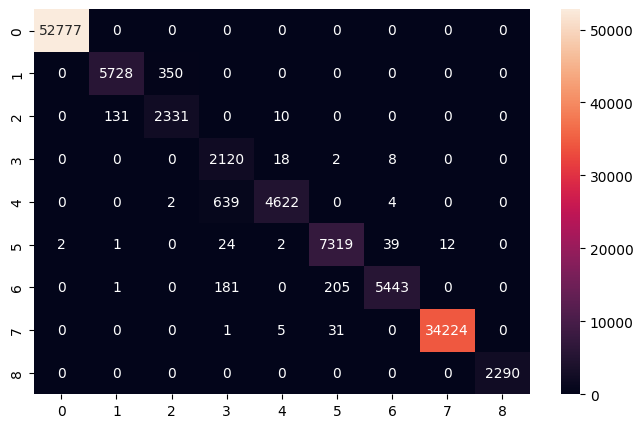

In [ ]:
######## load the model with the best performance on validation samples
from tensorflow.keras.models import load_model

model = load_model("Pavia_Model3.h5") # loading the model with the best validation metric

########## Results on test samples

pred = np.argmax(model.predict(X_test), axis=1) # predic for the the test samples

# Classification Report
print(classification_report(pred, np.argmax(y_test, 1)))

from sklearn.metrics import *
Kappa=cohen_kappa_score(np.argmax(y_test, 1),pred) # calculate Kappa coefficient
OA=accuracy_score(np.argmax(y_test, 1),pred) # calculate Overall accuracy
matrix = confusion_matrix(np.argmax(y_test, 1),pred) # calculate confusion matrix
Producer_accuracy= matrix.diagonal()/matrix.sum(axis=1) # calculate producer accuracy

print(f"Overall Accuracy: {OA*100}\nKappa coefficient: {Kappa}\nProducer accuracy: {Producer_accuracy*100} ")

# plot confusion matrix in a heatmap
plt.figure(figsize = (8,5))
df_cm = pd.DataFrame(matrix)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

######## delet unncessary varialbe to empty RAM
del pred, X, X_test, X_train, X_val, y, y_test, y_train, y_val


# Predicting whole image

24489/24489 [==============================] - 81s 3ms/step


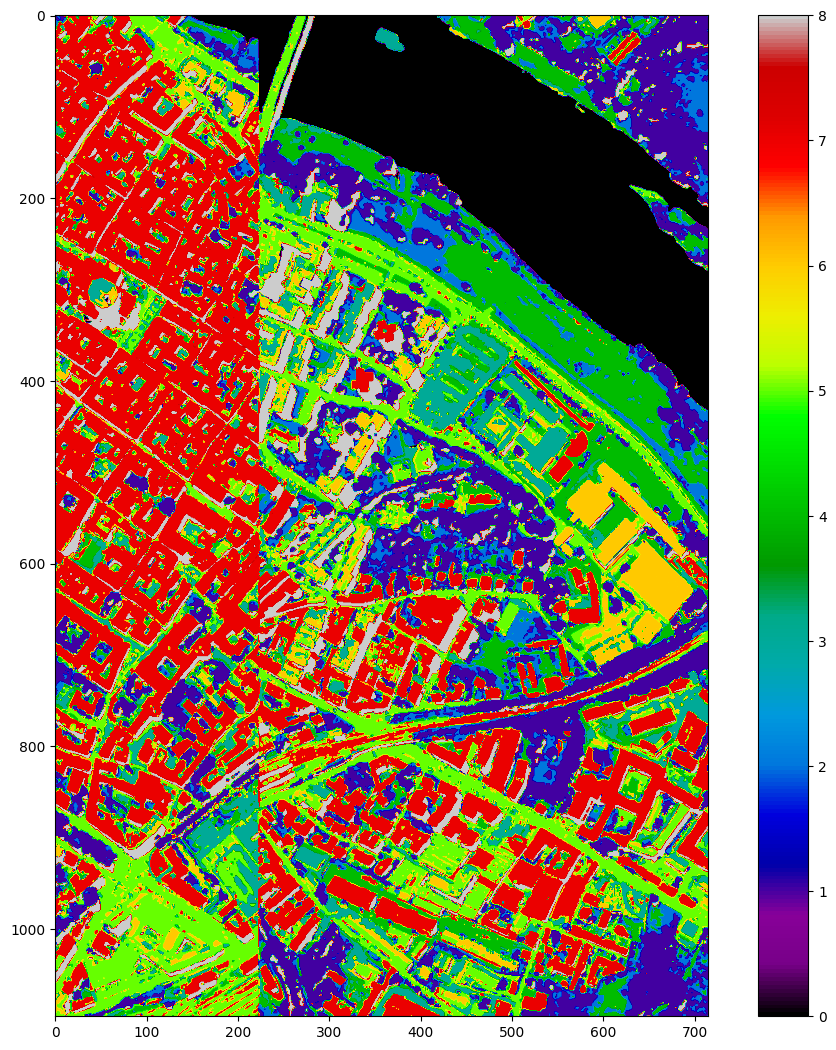

In [ ]:
X,_= ExtractPatches(data, windowSize=windowSize) #patches the image

########## scale the image patches
X=ScaleData(X,min_value,max_value)

####################

prediction = np.argmax(model.predict(X), axis=1) # predict each pathce's class

prediction_reshaped = prediction.reshape(data.shape[0],data.shape[1]) # reshape the prediced values to form an image

######## Plot the classified image
def plot_data(data):
  fig = plt.figure(figsize=(13, 13)) # open a figure
  plt.imshow(data, cmap='nipy_spectral') #plot the groud truth
  plt.colorbar() # add colorbar
  plt.axis('on') # Trun the axis on
  plt.show()

plot_data(prediction_reshaped)
